In [1]:
#%load_ext watermark
%load_ext autoreload 
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import json
from functools import partial
import matplotlib.pyplot as plt
from pybpr import *

In [3]:
from pybpr import *
data_dir = '/home/rsandhu/zazzle/raw_data'

In [4]:
# tdf = pd.read_csv(os.path.join(data_dir, 'ml-10M100K', 'tags.dat'), sep='::', engine='python', header=None)
# tdf.columns = ['UserID','MovieID','Tag','Timestamp']
# tdf.head()
tdf_tag = pd.read_csv(os.path.join(data_dir, 'tag-genome','tags.dat'), sep='\t', header=None)
tdf_tag.columns = ['TagID','Tag','TagPopularity']
tdf_tag.head(100)
# tdf_movie = pd.read_csv(os.path.join(data_dir, 'tag-genome','movies.dat'), sep='\t', header=None)
# tdf_movie.columns = ['MovieID','Title','MoviePopularity']
# tdf_movie.head()

,TagID,Tag,TagPopularity
0,0,007,61
1,1,007 (series),24
2,2,18th century,37
3,3,1920s,42
4,4,1930s,55
...,...,...,...
95,95,bad,21
96,96,bad acting,182
97,97,bad cgi,34
98,98,bad ending,104


In [5]:
data_dir = '/home/rsandhu/zazzle/raw_data'
mdf = pd.read_csv(os.path.join(data_dir, 'ml-10M100K','movies.dat'), sep='::', engine='python', header=None)
mdf.columns = ['MovieID', 'Title','Genres']
#mdf.set_index('MovieID', inplace=True)
mdf.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
tdf = pd.read_csv(os.path.join(data_dir, 'tag-genome','tag_relevance.dat'), sep='\t', header=None)
tdf.columns = ['MovieID','TagID','Relevance']
tdf.drop(index=tdf.index[tdf.Relevance < 0.8], inplace=True)
tdf.head()

,MovieID,TagID,Relevance
28,1,28,0.894
62,1,62,0.979
63,1,63,0.987
185,1,185,0.947
202,1,202,0.898


In [7]:
rdf = pd.read_csv(os.path.join(data_dir, 'ml-10M100K', 'ratings.dat'), sep='::', engine='python', header=None)
rdf.columns= ['UserID','MovieID','Rating','Timestamp']
rdf.head()

,UserID,MovieID,Rating,Timestamp
0,1,122,5.0,838985046
1,1,185,5.0,838983525
2,1,231,5.0,838983392
3,1,292,5.0,838983421
4,1,316,5.0,838983392


In [8]:
# rdf = rdf[rdf.MovieID.isin(tdf.MovieID.unique())]
# tdf = tdf[tdf.MovieID.isin(rdf.MovieID.unique())]
# rdf.MovieID.nunique(), tdf.MovieID.nunique(), tdf.TagID.nunique()

In [9]:
ui = UserItemData(name='User-Metadata-only')
rdf = rdf[rdf.MovieID.isin(tdf.MovieID.unique())]
ui.add_positive_interactions(
     user_ids=rdf.UserID[rdf.Rating>=4.], 
     item_ids=rdf.MovieID[rdf.Rating>=4.]
)
ui.add_negative_interactions(
    user_ids=rdf.UserID[rdf.Rating<4.], 
    item_ids=rdf.MovieID[rdf.Rating<4.]
)
ui.add_user_features(
    user_ids=rdf.UserID.unique(), 
    feature_ids=rdf.UserID.unique()
)
ui.add_item_features(
     item_ids=tdf.MovieID, 
     feature_ids=tdf.TagID
)
ui

UserItemData(User-Metadata-only)
  Fuser     :( 69878× 69878) nnz=    69,878 (0.001%), empty rows/cols=     0/     0
  Fitem     :(  9542×  1096) nnz=   101,624 (0.972%), empty rows/cols=     0/     0
  Rpos      :( 69878×  9542) nnz= 4,986,252 (0.748%), empty rows/cols=    81/  1326
  Rneg      :( 69878×  9542) nnz= 4,940,884 (0.741%), empty rows/cols=    88/  1303

In [10]:
ui.train_test_split(train_ratio_pos=0.8, train_ratio_neg=0.8, show_progress=True)

Train/Test Split (Cols): 100%|██████████| 1307/1307 [02:19<00:00,  9.39it/s]


In [11]:
adam = partial(
    torch.optim.Adam,
    lr=0.02,
    weight_decay=0.0
)
rs = RecSys(
    data = ui,
    model= HybridMF(ui.n_user_features, ui.n_item_features, n_latent=64),
    optimizer=partial(torch.optim.Adam, lr=0.05, weight_decay=0.0),
    output_dir='/kfs2/projects/zazzle/pybpr/notebooks/output/ml-run',
    loss_function=bpr_loss,
    log_level=2
)
rs

INFO - Initiating Hybrid Recommender System..
INFO - Output directory set to: /kfs2/projects/zazzle/pybpr/notebooks/output/ml-run
INFO - Got 68088 users for train/test


RecSys(
Data=UserItemData(User-Metadata-only)
  Fuser     :( 69878× 69878) nnz=    69,878 (0.001%), empty rows/cols=     0/     0
  Fitem     :(  9542×  1096) nnz=   101,624 (0.972%), empty rows/cols=     0/     0
  Rpos      :( 69878×  9542) nnz= 4,986,252 (0.748%), empty rows/cols=    81/  1326
  Rneg      :( 69878×  9542) nnz= 4,940,884 (0.741%), empty rows/cols=    88/  1303
  Rpos_train:( 69878×  9542) nnz= 3,989,026 (0.598%), empty rows/cols=    81/  1326
  Rpos_test :( 69878×  9542) nnz=   997,226 (0.150%), empty rows/cols=  1790/  1632
  Rneg_train:( 69878×  9542) nnz= 3,952,753 (0.593%), empty rows/cols=    88/  1303
  Rneg_test :( 69878×  9542) nnz=   988,131 (0.148%), empty rows/cols=  3340/  1366
Model=HybridMF(
  (user_latent): Embedding(69878, 64)
  (item_latent): Embedding(1096, 64)
  (item_biases): Embedding(1096, 1)
)
Optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach:

In [15]:
rs.fit(n_iter=10, eval_every=1, batch_size=10000, eval_user_size=10000)

INFO - # of minibatches = 7
INFO - Eval frequency = 1 epochs


HybBPR:   0%|          | 0/10 [00:05<?, ?it/s, loss=0.7017]

DEBUG - Model state dict saved to /kfs2/projects/zazzle/pybpr/notebooks/output/ml-run/best_model_epoch_7.torch
DEBUG - Eval@7: AUC (train/test): 0.740/0.645, Loss (train/test): 0.000/0.000


HybBPR:  10%|█         | 1/10 [00:44<05:35, 37.29s/it, loss=0.7108]

DEBUG - Model state dict saved to /kfs2/projects/zazzle/pybpr/notebooks/output/ml-run/best_model_epoch_8.torch
DEBUG - Eval@8: AUC (train/test): 0.742/0.646, Loss (train/test): 0.000/0.000


HybBPR:  20%|██        | 2/10 [01:21<05:01, 37.66s/it, loss=0.7133]

DEBUG - Model state dict saved to /kfs2/projects/zazzle/pybpr/notebooks/output/ml-run/best_model_epoch_9.torch
DEBUG - Eval@9: AUC (train/test): 0.754/0.648, Loss (train/test): 0.000/0.000


HybBPR:  30%|███       | 3/10 [01:58<04:20, 37.17s/it, loss=0.7159]

DEBUG - Model state dict saved to /kfs2/projects/zazzle/pybpr/notebooks/output/ml-run/best_model_epoch_10.torch
DEBUG - Eval@10: AUC (train/test): 0.758/0.652, Loss (train/test): 0.000/0.000


HybBPR:  40%|████      | 4/10 [02:36<03:46, 37.73s/it, loss=0.7200]

DEBUG - Eval@11: AUC (train/test): 0.761/0.648, Loss (train/test): 0.000/0.000


HybBPR:  50%|█████     | 5/10 [03:14<03:07, 37.44s/it, loss=0.7235]

DEBUG - Eval@12: AUC (train/test): 0.766/0.650, Loss (train/test): 0.000/0.000


HybBPR:  60%|██████    | 6/10 [03:53<02:31, 37.90s/it, loss=0.7172]

DEBUG - Model state dict saved to /kfs2/projects/zazzle/pybpr/notebooks/output/ml-run/best_model_epoch_13.torch
DEBUG - Eval@13: AUC (train/test): 0.769/0.654, Loss (train/test): 0.000/0.000


HybBPR:  70%|███████   | 7/10 [04:44<01:54, 38.24s/it, loss=0.7388]

DEBUG - Eval@14: AUC (train/test): 0.771/0.649, Loss (train/test): 0.000/0.000


HybBPR:  80%|████████  | 8/10 [05:22<01:23, 41.99s/it, loss=0.7391]

DEBUG - Eval@15: AUC (train/test): 0.775/0.652, Loss (train/test): 0.000/0.000


HybBPR:  90%|█████████ | 9/10 [06:00<00:40, 40.58s/it, loss=0.7560]

DEBUG - Eval@16: AUC (train/test): 0.776/0.648, Loss (train/test): 0.000/0.000


HybBPR: 100%|██████████| 10/10 [06:34<00:00, 39.42s/it, loss=0.7560]


In [14]:
rs.metrics

[{'epoch': 1, 'loss': 0.6299952837614374},
 {'epoch': 2,
  'loss': 0.7695699725626163,
  'test_auc': 0.653149978432366,
  'test_auc_std': 0.2194561228671245,
  'test_loss': 0.0007047600746154785,
  'train_auc': 0.6939621668687586,
  'train_auc_std': 0.10988661526388788,
  'train_loss': 0.0006815142631530762},
 {'epoch': 3,
  'loss': 0.724699718833684,
  'test_auc': 0.636396860499319,
  'test_auc_std': 0.2096017512552128,
  'test_loss': 0.0007047143578529358,
  'train_auc': 0.6945069483835876,
  'train_auc_std': 0.1094402948419376,
  'train_loss': 0.0007735777497291565},
 {'epoch': 4,
  'loss': 0.7261757818221933,
  'test_auc': 0.6388720433969037,
  'test_auc_std': 0.21241097998919076,
  'test_loss': 0.000722014307975769,
  'train_auc': 0.709095098435218,
  'train_auc_std': 0.114037661775915,
  'train_loss': 0.0007301946878433228},
 {'epoch': 5,
  'loss': 0.7119454762207581,
  'test_auc': 0.6505535029299582,
  'test_auc_std': 0.21716113741790566,
  'test_loss': 0.0006746781468391418,
  

In [54]:
%%time
xx = get_user_interactions(users=rs.users[:4000], pos_csr_mat=rs.Rpos_train_csr, neg_csr_mat=rs.Rneg_train_csr, neg_ratio=1.)

CPU times: user 4.32 ms, sys: 21 μs, total: 4.34 ms
Wall time: 4.33 ms


In [55]:
%%time
yy = compute_auc_scores(xx, rs.predict)

CPU times: user 2min 21s, sys: 6.51 s, total: 2min 28s
Wall time: 7.06 s


In [61]:
compute_roc_auc_score_all_items(
    pred_scores=rs.model.predict(rs.Fu_csr, rs.Fi_csr),
    pos_csr_mat=rs.Rpos_train_csr,
    neg_csr_mat=rs.Rneg_train_csr,
    neg_ratio= 1.,
    n_jobs
)

TypeError: Cannot interpret 'torch.float32' as a data type

In [31]:
yy[:2]

[(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int8),
  array([-0.1479168 , -0.5295189 ,  1.9289935 ,  3.309327  ,  0.11100793,
          0.4668362 ,  3.3421235 ,  4.204011  ,  2.1579344 ,  1.1569982 ,
          6.5093327 ,  3.0115273 ,  1.1062804 ,  4.5743637 ,  2.1059036 ,
          3.8325639 ,  3.31386   , -0.65143704,  2.8454125 , -0.22279662,
         -1.9697559 ,  3.6011455 ,  0.23351169, -1.596878  ,  0.13656744,
          0.757073  , -0.8124689 ,  0.04837009,  2.1920722 , -0.07151139,
         -1.9428208 , -0.20091152,  1.8935213 , -0.41208476], dtype=float32),
  0.8131487889273357),
 (array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int8),
  array([13.416822  , 11.780233  ,  3.83111   ,  4.267367  ,  7.849419  ,
         -0.18637717, -1.9407303 , -1.8887002 ,  3.8114448 ,  1.2509985 ,
          0.7703401 ,  3.213985  , -0.26417336, -0.14909786], dtype=float32),
  1.0)]

In [59]:
yy = rs.model.predict(rs.Fu_csr, rs.Fi_csr)
yy.shape

torch.Size([69878, 9542])

In [57]:
# for (ix, px, nx), (y_true, y_pred, roc) in zip(xx,yy):
#     print(ix, len(px), len(nx))

train_loss
test_loss
train_auc
test_auc


INFO - Saved metrics plot to /kfs2/projects/zazzle/pybpr/notebooks/output/ml-run/metrics_plot.png


(<Figure size 1200x800 with 2 Axes>,
 {'loss': <Axes: xlabel='Epoch', ylabel='BPR Loss'>,
  'auc': <Axes: title={'center': 'Train/Test Metrics'}, ylabel='ROC AUC'>},
    epoch      loss  test_loss  test_auc  test_n_users_evaluated  train_loss  \
 0      1  0.620579        NaN       NaN                     NaN         NaN   
 1      2  0.544853   0.553014  0.706637                  1000.0    0.505721   
 2      3  0.521712        NaN       NaN                     NaN         NaN   
 3      4  0.502978   0.627560  0.674150                  1000.0    0.534143   
 4      5  0.482434        NaN       NaN                     NaN         NaN   
 5      6  0.469729   0.601684  0.689567                  1000.0    0.483711   
 6      7  0.456158        NaN       NaN                     NaN         NaN   
 7      8  0.445131   0.634435  0.682475                  1000.0    0.435836   
 8      9  0.429239        NaN       NaN                     NaN         NaN   
 9     10  0.422002   0.652046  0.

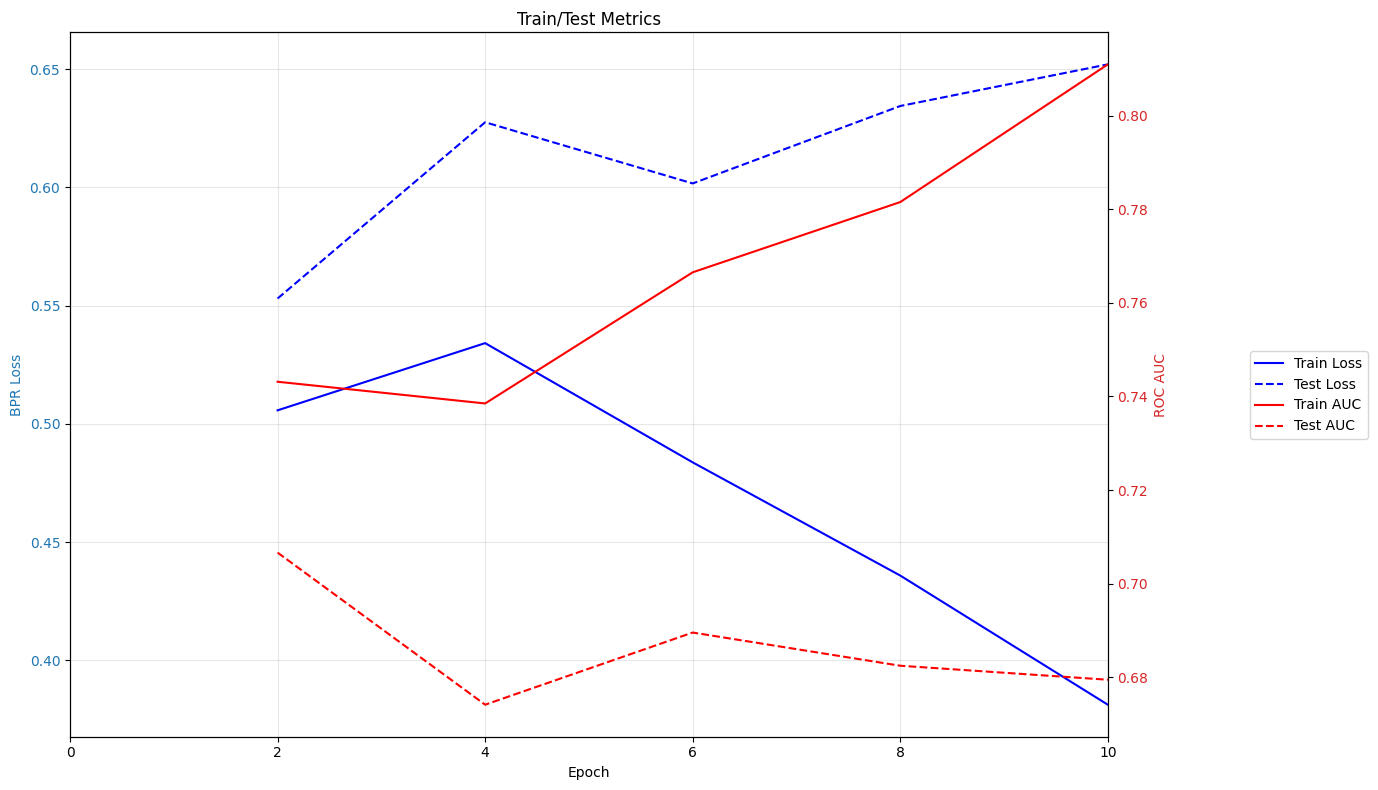

In [14]:
RecSys.plot_metrics(metrics_filepath='/kfs2/projects/zazzle/pybpr/notebooks/output/ml-run/metrics.json')

In [ ]:
pred_scores = rs.model.predict(
    user_features=scipy_csr_to_torch_csr(rs.Fu_csr),
    item_features=scipy_csr_to_torch_csr(rs.Fi_csr)
)
pred_scores.shape

In [ ]:
%%time
xx = compute_roc_auc_score_for_all_items(
    pred_scores=pred_scores.detach().numpy(),
    pos_csr_mat=rs.Rpos_train_csr,
    neg_csr_mat=rs.Rneg_train_csr,
    neg_ratio=1.,
    n_jobs=64
)

In [ ]:
np.array_split([0,1,2,3,4,5,6,7],3)

In [ ]:
users, pos_items, neg_items = sample_pos_neg_pairs(
    pos_csr_mat=rs.Rpos_train_csr,
    neg_csr_mat=rs.Rneg_train_csr,
    user_indices=[0,1,2,3]
)
Fu_sliced = scipy_csr_to_torch_csr(rs.Fu_csr[users, :])
Fi_sliced_pos = scipy_csr_to_torch_csr(rs.Fi_csr[pos_items, :])
Fi_sliced_neg = scipy_csr_to_torch_csr(rs.Fi_csr[neg_items, :])
r_ui = rs.model(
    user_features=Fu_sliced,
    item_features=Fi_sliced_pos
)
r_uj = rs.model(
    user_features=Fu_sliced,
    item_features=Fi_sliced_neg
)
    
users, pos_items, neg_items, r_ui, r_uj

In [ ]:
Fi_sliced_pos.to_sparse_coo()

In [ ]:
rs.Fu_csr, rs.Fi_csr, rs.model.user_latent.weight.shape

In [ ]:
r_ui = rs.model.predict(
    user_features=scipy_csr_to_torch_csr(rs.Fu_csr),
    item_features=scipy_csr_to_torch_csr(rs.Fi_csr)
)

In [ ]:
xx = rs.Rpos_train_csr - rs.Rneg_train_csr
roc_auc_score(xx, r_ui)

In [ ]:
 rs.Rpos_train_csr ,rs.Rneg_train_csr

In [ ]:
from sklearn.metrics import roc_auc_score
true_labels = rs.Rpos_csr

In [ ]:
np.sum(rs.Fi_csr.getnnz(axis=1) == 0)

In [ ]:
ui.Fi.tocsr()[8015]

In [ ]:
pos = rs.Rpos_train_csr.tolil()
neg = rs.Rneg_train_csr.tolil()
pos.rows[3], neg.rows[3]

In [ ]:
rs.fit(n_iter=10, batch_size=10000, eval_every=1, eval_user_size=200000, early_stopping_patience=200)

In [ ]:
rs.metrics

In [ ]:
row_nnz = rs.Fi_csr.getnnz(axis=1)
np.sum(row_nnz==0)

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score().item()

In [ ]:
y_true=np.array([1,1,1,1,1,-1,-1,-1,-1,-1])
y_score=np.array([5,40,3,0,10,0,-1,-20,-30,-40])
batch_roc = roc_auc_score(y_true, y_score).item()
user_roc = []
n=len(y_true)//2
for ix in range(n):
    user_roc.append(roc_auc_score(y_true[[ix,ix+n]], y_score[[ix,ix+n]]).item())
np.average(user_roc).item(), batch_roc

In [ ]:
user_roc

In [ ]:
RecSys.plot_metrics('/kfs2/projects/zazzle/pybpr/notebooks/output/ml-run/metrics.json')

In [ ]:
rs.fit(n_iter=10, batch_size=10000, eval_every=2)

In [ ]:
pos = np.array(ui.Rpos.getnnz(axis=1))
neg = np.array(ui.Rneg.getnnz(axis=1))
ratio = np.divide(neg, pos)
ratio = ratio[~np.isnan(ratio)]
ratio = ratio[~np.isinf(ratio)]


In [ ]:
#plt.hist(pos, bins=50)
plt.hist(ratio, bins=50, range=(0,4))

In [ ]:
Rneg_csr = ui.Rneg.tocsr()
random_col_for_row(Rneg_csr, [13,13,13])

In [ ]:
row_index = 1000
csr_matrix=ui.Rpos.tocsr()
row_start = csr_matrix.indptr[row_index]
row_end = csr_matrix.indptr[row_index + 1]

# Get the column indices of nonzero elements in this row
nonzero_col_indices = csr_matrix.indices[row_start:row_end]
nonzero_col_indices

In [ ]:
random_col_for_row(ui.Rneg.tocsr(), [row_index for _ in range(20)])

In [ ]:
np.concatenate((user_neg_items, np.random.choice([1,2,3,4],3)))


In [ ]:
adam = partial(
    torch.optim.Adam,
    lr=0.02,
    weight_decay=0.0
)
rs = RecSys(
    data = ui,
    model= HybridMF(ui.n_user_features, ui.n_item_features, n_latent=64),
    optimizer=partial(torch.optim.Adam, lr=0.02, weight_decay=0.0),
    output_dir='/kfs2/projects/zazzle/pybpr/notebooks/output/ml-run',
    log_level=1
)
rs

In [ ]:
rs.model

In [ ]:
rs.fit(n_iter=20, eval_every=20, eval_sample_size=5000)

In [ ]:
rs.model

In [ ]:
xx=[1,2,4,5,6,7,8]
xx = np.random.choice(xx)
xx

In [ ]:
import json
output_dir='/kfs2/projects/zazzle/pybpr/examples/output/movielens'
lr = 0.1
filepath = os.path.join(output_dir, 'metadata_nl32_lr1_ns', 'metrics.json')
fig, axs, metrics = RecSys.plot_metrics(filepath, figsize=(10,4))
axs['auc'].set_ylim([0.6,0.8])

filepath = os.path.join(output_dir, 'metadata_nl64_lr1_ns', 'metrics.json')
fig, axs, metrics = RecSys.plot_metrics(filepath, figsize=(10,4))
axs['auc'].set_ylim([0.6,0.8])

filepath = os.path.join(output_dir, 'metadata_nl128_lr1_ns', 'metrics.json')
fig, axs, metrics = RecSys.plot_metrics(filepath, figsize=(10,4))
axs['auc'].set_ylim([0.6,0.8])

In [ ]:
import json
output_dir='/kfs2/projects/zazzle/pybpr/examples/output/movielens'
lr = 0.1
filepath = os.path.join(output_dir, 'indicator_nl64_lr1_ns', 'metrics.json')
fig, axs, metrics = RecSys.plot_metrics(filepath, figsize=(10,4))
#axs['auc'].set_ylim([0.6,0.8])

filepath = os.path.join(output_dir, 'metadata_nl64_lr1_ns', 'metrics.json')
fig, axs, metrics = RecSys.plot_metrics(filepath, figsize=(10,4))
#axs['auc'].set_ylim([0.6,0.8])

filepath = os.path.join(output_dir, 'both_nl64_lr1_ns', 'metrics.json')
fig, axs, metrics = RecSys.plot_metrics(filepath, figsize=(10,4))
#axs['auc'].set_ylim([0.6,0.8])

In [ ]:
import json
output_dir='/kfs2/projects/zazzle/pybpr/examples/output/movielens'
lr = 0.1
filepath = os.path.join(output_dir, 'indicator_nl64_lr1', 'metrics.json')
fig, axs, metrics = RecSys.plot_metrics(filepath, figsize=(10,4))
#axs['auc'].set_ylim([0.6,0.8])

filepath = os.path.join(output_dir, 'metadata_nl64_lr1', 'metrics.json')
fig, axs, metrics = RecSys.plot_metrics(filepath, figsize=(10,4))
#axs['auc'].set_ylim([0.6,0.8])

filepath = os.path.join(output_dir, 'both_nl64_lr1', 'metrics.json')
fig, axs, metrics = RecSys.plot_metrics(filepath, figsize=(10,4))
#axs['auc'].set_ylim([0.6,0.8])

In [ ]:
output_dir='/kfs2/projects/zazzle/pybpr/examples/output/movielens_check'
filepath = os.path.join(output_dir, 'indicator_nl64_lr1', 'metrics.json')
fig, axs, metrics = RecSys.plot_metrics(filepath, figsize=(10,4))

filepath = os.path.join(output_dir, 'metadata_nl64_lr1', 'metrics.json')
fig, axs, metrics = RecSys.plot_metrics(filepath, figsize=(10,4))

filepath = os.path.join(output_dir, 'both_nl64_lr1', 'metrics.json')
fig, axs, metrics = RecSys.plot_metrics(filepath, figsize=(10,4))

In [ ]:
axs['auc']

In [ ]:
import json
output_dir='/kfs2/projects/zazzle/pybpr/examples/output/movielens'
filepath = os.path.join(output_dir, 'indicator_nl64_lr5', 'metrics.json')
fig, axs, metrics = RecSys.plot_metrics(filepath, figsize=(10,4))

filepath = os.path.join(output_dir, 'metadata_nl64_lr5', 'metrics.json')
fig, axs, metrics = RecSys.plot_metrics(filepath, figsize=(10,4))

filepath = os.path.join(output_dir, 'both_nl64_lr5', 'metrics.json')
fig, axs, metrics = RecSys.plot_metrics(filepath, figsize=(10,4))


In [ ]:
metrics

In [ ]:
metrics[metrics.test_auc_mean.notna()]

In [ ]:
fig

In [ ]:
get_matrix_stats(ui.Rneg), get_matrix_stats(ui.Rneg_train), get_matrix_stats(ui.Rneg_test)

In [ ]:
random_col_for_row(matrix=ui.Rpos, row_idx=[0,0,0,0])
random_col_for_row(matrix=ui.Rneg, row_idx=[0,0,0,0])

In [ ]:
min(12,13,14)

In [ ]:
get_matrix_stats(ui.Rpos), get_matrix_stats(ui.Rpos_train)

In [ ]:
csr_pos = ui.Rneg.tocsr()
user_row_counts = np.diff(csr_pos.indptr)
active_users = np.where(user_row_counts > 0)[0]
inactive_users = np.where(user_row_counts == 0)[0]
active_user_set = set(active_users)

In [ ]:
ui.Rneg, ui.Rpos, ui.Fi, ui.Fu, ui.Rpos_train

In [ ]:
len(ui._user_id_to_idx),rdf.UserID[rdf.Rating>=4.].nunique(),rdf.UserID[rdf.Rating<4.].nunique(), rdf.UserID.nunique()
#len(ui._item_id_to_idx),rdf.MovieID[rdf.Rating>=4.].nunique(), rdf.MovieID[rdf.Rating<4.].nunique(), rdf.MovieID.nunique()

In [ ]:
len(ui._user_id_to_idx),rdf.UserID[rdf.Rating<4.].nunique()
len(ui._item_id_to_idx),

In [ ]:
len(active_user_set), len(inactive_users)
find_empty_rows_cols(ui.Rneg)

In [ ]:
adam = partial(
    torch.optim.Adam,
    lr=0.1,
    weight_decay=0.0
)
rs = RecSys(
    ui_data = ui,
    n_latent=64,
    optimizer=adam,
    verbose=False
)
rs

In [ ]:
rs.fit(n_iter=100, batch_size=100000)

In [ ]:
rs._log

In [ ]:
ui.validate_data()

In [ ]:
ui.Rneg, ui.Rpos, ui.Fu, ui.Fi

In [ ]:
find_empty_rows_cols(ui.Rpos)

In [ ]:
import numpy as np
from scipy import sparse

def find_empty_rows_cols(coo_matrix):
    """
    Find rows and columns that have no non-zero elements in a scipy sparse COO matrix.
    
    Parameters:
    -----------
    coo_matrix : scipy.sparse.coo_matrix
        The sparse matrix in COO format
    
    Returns:
    --------
    empty_rows : numpy.ndarray
        Indices of rows with no non-zero elements
    empty_cols : numpy.ndarray
        Indices of columns with no non-zero elements
    """
    # Get matrix dimensions
    n_rows, n_cols = coo_matrix.shape
    
    # Find rows that have at least one non-zero element
    rows_with_data = np.unique(coo_matrix.row)
    
    # Find columns that have at least one non-zero element
    cols_with_data = np.unique(coo_matrix.col)
    
    # Create arrays with all possible row and column indices
    all_rows = np.arange(n_rows)
    all_cols = np.arange(n_cols)
    
    # Find rows and columns without data using set difference
    empty_rows = np.setdiff1d(all_rows, rows_with_data)
    empty_cols = np.setdiff1d(all_cols, cols_with_data)
    
    return empty_rows, empty_cols

In [ ]:
_ = ui.train_test_split()

In [ ]:
ui = UserItemData(name='User-Metadata-only')
ui.add_positive_interactions(
    user_indices=rdf.UserID_ids[rdf.Rating>=4.], 
    item_indices=rdf.MovieID_ids[rdf.Rating>=4.]
)
ui.add_negative_interactions(
    user_indices=rdf.UserID_ids[rdf.Rating<4.], 
    item_indices=rdf.MovieID_ids[rdf.Rating<4.]
)
ui.add_user_features(
    user_indices=list(range(ui.n_users)), 
    feature_indices=list(range(ui.n_users))
)
ui.add_item_features(
    item_indices=tdf.MovieID_ids, 
    feature_indices=tdf.TagID_ids,
    #feature_weights=tdf.Relevance
)
ui.train_test_split(0.2)
ui

In [ ]:
csr = ui.Rpos_coo.tocsr()
np.unique(csr.nonzero()[0])

In [ ]:
n_items = rdf.MovieID.nunique()
n_users = rdf.UserID.nunique()
n_item_mfeatures = tdf.TagID.nunique()

In [ ]:
n_items = rdf.MovieID.nunique()
n_users = rdf.UserID.nunique()
n_item_mfeatures = tdf.TagID.nunique()
ui_metadata = UserItemData(
    name='User-Metadata-only',
    n_users=n_users, 
    n_items = n_items,
    n_user_features=n_users,
    n_item_features=n_item_mfeatures
    
)
ui_metadata.add_interactions(
    user_indices=rdf.UserID_ids[rdf.Rating>=4.], 
    item_indices=rdf.MovieID_ids[rdf.Rating>=4.],
    positive=True
)
ui_metadata.add_interactions(
    user_indices=rdf.UserID_ids[rdf.Rating<4.], 
    item_indices=rdf.MovieID_ids[rdf.Rating<4.],
    positive=False
)
ui_metadata.add_user_features(
    user_indices=list(range(n_users)), 
    feature_indices=list(range(n_users))
)
ui_metadata.add_item_features(
    item_indices=tdf.MovieID_ids, 
    feature_indices=tdf.TagID_ids,
    #feature_weights=tdf.Relevance
)
ui_metadata.train_test_split(0.2)
ui_metadata

In [ ]:
adam = partial(
    torch.optim.Adam,
    lr=0.1,
    weight_decay=0.0
)
rs = RecSys(
    ui_data = ui_metadata,
    n_latent=64,
    optimizer=adam,
    verbose=False
)
rs
#rs.fit(n_iter=50, batch_size=100000, verbose=False)

In [ ]:
rs.fit(n_iter=100, batch_size=100000)

In [ ]:
# rs.fit(n_iter=5, batch_size=100000)

In [ ]:
rs.predict(user_ids=[0,1,2],item_ids=[123, 11]).detach()

In [ ]:
auc_mean = np.array([iy for ix,iy,iz in rs.auc_tracker])
auc_std = np.array([iz for ix,iy,iz in rs.auc_tracker])
epochs = list(range(len(rs.loss_tracker)))

fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(epochs, rs.loss_tracker, '-r', label='BPR_LOSS')
ax[1].plot(epochs, auc_mean, '-b', label='Auc Score')
ax[1].fill_between(epochs, auc_mean-1*auc_std, auc_mean+1*auc_std, color='b', alpha=0.2)
#ax[1].set_ylim([0,1])
for iax in ax:
    iax.legend()

In [ ]:
valid_users = np.unique(rs.Rpos_train_coo.row)
for uid in valid_users:
    rs.compute_roc_auc_score(uid)

In [ ]:
valid_users = np.unique(rs.Rpos_train_coo.row)
valid_items_pos = np.unique(rs.Rpos_train_coo.col)
valid_items_neg = np.unique(rs.Rpos_train_coo.col)

In [ ]:
rs.Rpos_train_coo, rs.Rpos_train_lil, rs.Rpos_train_coo.tolil()

In [ ]:
rs.data.Rpos_coo, rs.Rpos_train_coo, rs.Rpos_test_coo

In [ ]:
rs.Rpos_train_lil.rows[uid]

In [ ]:
# ROC_AUC metric
list_of_auc = []
for uid in np.random.choice(valid_users, 100):
    item_ids_pos = rs.Rpos_train_lil.rows[uid]
    item_ids_neg = rs.Rneg_lil.rows[uid]
    if (len(item_ids_pos) > 5) & (len(item_ids_neg) > 5):
        item_ids = np.concatenate((item_ids_pos, item_ids_neg))
        ytrue_binary = np.zeros(len(item_ids), dtype=int)
        ytrue_binary[:len(item_ids_pos)] = 1
        ypred = rs.predict(
            user_ids=[uid],
            item_ids=item_ids
        )
        inds_sorted = np.argsort(ypred.squeeze().tolist())[::-1][:len(item_ids_pos)]
        ypred_binary = np.zeros(len(item_ids), dtype=int)
        ypred_binary[inds_sorted] = 1
        #ypred = torch.heaviside(ypred, torch.tensor([0.])).squeeze().tolist()
        #print(uid, len(ypred), len(ytrue),  len(item_ids))
        auc_score = sklearn.metrics.roc_auc_score(ytrue_binary, ypred_binary)
        #print(ytrue, ypred, auc_score)
    list_of_auc.append(auc_score)

In [ ]:
list_of_auc

In [ ]:
for ix,iy in zip(ytrue_binary, ypred_binary):
    print(ix, iy)

In [ ]:
vals, inds = torch.sort(ypred, descending=True)
[ix for ix in inds[:len(item_ids_pos)]], len(item_ids_pos)

In [ ]:
ypred = [0 for _ in range(len(item_ids))]
ypred[inds[:len(item_ids_pos)]] = 

In [ ]:
xx = np.zeros(10)
xx[[2,3]] = 1.
xx

In [ ]:
uid = 964
item_ids_pos = rs.Rpos_train_lil.rows[uid]
item_ids_neg = rs.Rneg_lil.rows[uid]
print(len(item_ids_pos), len(item_ids_neg))
item_ids = item_ids_pos + item_ids_neg
ytrue = rs.Rpos_train_lil.data[uid]
#ytrue += [0 for ix in rs.Rneg_lil.data[uid]]
print(len(item_ids), len(ytrue))

In [ ]:
for ix, iy in zip(ytrue, ypred):
    print(ix, iy)

In [ ]:
list_of_auc

In [ ]:
for ix,iy, iz in zip(iids, pdata, xx):
    print(ix, iy, iz)

In [ ]:
users = np.unique(rs.Rpos_test_coo.row)
len(users)
xx = rs.predict(users)
print(xx.shape)
xx = torch.tanh(xx)
#xx -= torch.min(xx)
#xx /= torch.max(xx)
#xx = torch.nn.functional.softmax(xx, dim=0)

print(xx.shape)

In [ ]:
yy = rs.Rpos_test_csr[users].tocoo()
values = yy.data
indices = np.vstack((yy.row, yy.col))

i = torch.LongTensor(indices)
v = torch.FloatTensor(values)
shape = yy.shape

yyy = torch.sparse.FloatTensor(i, v, torch.Size(shape))


In [ ]:
# numpy_array = xx.detach().numpy()
hist, bin_edges = torch.histogram(xx, bins=10)
# Plot the histogram
plt.plot(bin_edges.detach().numpy()[:-1], hist.detach().numpy())
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of PyTorch Tensor')
plt.show()

In [ ]:
y_pred = torch.flatten(xx.detach())
y_true = torch.flatten(yyy.to_dense())
y_pred, y_true

In [ ]:
import torch
import sklearn
from torcheval.metrics import BinaryAUROC, AUC



# # Sample data
y_true = torch.tensor([1, 0, 1, 0, 1, 0])
y_pred = torch.tensor([0, -1, 0, -0.4, 0.4, 0.4])
y_pred = torch.tensor([1, 0, 1, 0, 1, 0])
#y_pred = torch.tensor([1, 0, 1, 1, 0, 1])

# # Create the metric object
# auroc = AUC()

# # Update the metric with your data
# auroc.update(y_pred, y_true.to_dense())

# # Compute the AUC-ROC score
# #score = auroc.compute()

sklearn.metrics.roc_auc_score(y_true, y_pred)

In [ ]:
xx[0].shape, yyy[0].shape

In [ ]:
rs.model.user_latent

In [ ]:
ui_indicator = UserItemData(
    n_users=n_users, 
    n_items = n_items,
    n_user_features=n_users,
    n_item_features=n_items
    
)
ui_indicator.add_interactions(
    user_indices=rdf.UserID_ids, 
    item_indices=rdf.MovieID_ids,
    weights=rdf.Weights
)
ui_indicator.add_user_features(
    user_indices=list(range(n_users)), 
    feature_indices=list(range(n_users))
)
ui_indicator.add_item_features(
    item_indices=list(range(n_items)), 
    feature_indices=list(range(n_items)),
)
ui_indicator

In [ ]:
ui_both = UserItemData(
    n_users=n_users, 
    n_items = n_items,
    n_user_features=n_users,
    n_item_features=n_items + n_item_mfeatures
    
)
ui_both.add_interactions(
    user_indices=rdf.UserID_ids, 
    item_indices=rdf.MovieID_ids,
    weights=rdf.Weights
)
ui_both.add_user_features(
    user_indices=list(range(n_users)), 
    feature_indices=list(range(n_users))
)
ui_both.add_item_features(
    item_indices=list(range(n_items)) + list(tdf.MovieID_ids), 
    feature_indices=list(range(n_items)) + [ix+n_items for ix in tdf.TagID_ids],
)
ui_both

In [ ]:
list(range(5))

In [ ]:
adam = partial(
    torch.optim.Adam,
    lr=0.13,
    weight_decay=0.001
)
sgd = partial(
    torch.optim.SGD,
    lr=0.13,
    weight_decay=0.001
)

In [ ]:
rs_metadata = RecSys(
    ui_data = ui_metadata,
    n_latent=64,
    optimizer=adam
)
rs_metadata.fit(n_iter=50, batch_size=100000, verbose=False)

In [ ]:
rs_indicator = RecSys(
    ui_data = ui_indicator,
    n_latent=64,
    optimizer=adam
)
rs_indicator.fit(n_iter=50, batch_size=100000, verbose=False)

In [ ]:
rs_both = RecSys(
    ui_data = ui_both,
    n_latent=64,
    optimizer=adam
)
rs_both.fit(n_iter=50, batch_size=100000, verbose=False)

In [ ]:
rs_both_sgd = RecSys(
    ui_data = ui_both,
    n_latent=64,
    optimizer=sgd
)
rs_both_sgd.fit(n_iter=50, batch_size=100000, verbose=False)

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(rs_indicator.loss_tracker, '-r', label='item-indicator-features-only')
ax.plot(rs_metadata.loss_tracker, '-b', label='item-metadata-features-only')
ax.plot(rs_both.loss_tracker, '-g', label='item-metadata+indicator-features')
ax.legend()

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(rs_indicator.loss_tracker, '-r', label='item-indicator-features-only')
ax.plot(rs_metadata.loss_tracker, '-b', label='item-metadata-features-only')
ax.plot(rs_both.loss_tracker, '-g', label='item-metadata+indicator-features')
ax.legend()

In [ ]:
rs.Rneg_coo.shape

In [ ]:
# look at validation loss as well if you see these oscillations
